# 🕸️ Yazılım Tedarik Zincirinde Kritiklik Haritalaması
## NPM Ekosisteminde Topolojik Risk Analizi

Bu notebook, NPM paket ekosistemini **kompleks ağ teorisi** perspektifinden analiz eder.

## 🎯 Amaç

NPM paketleri arasındaki bağımlılık ilişkilerini yönlü bir graf olarak modelleyip:
- Kritik altyapı paketlerini tespit etmek
- Topolojik riski ölçmek (in-degree, out-degree, betweenness)
- Kaskad etki potansiyelini değerlendirmek
- Gephi görselleştirme dosyaları üretmek

## 📊 Yöntem

1. **Veri Toplama:** ecosyste.ms API ile Top N en popüler paket
2. **Ağ Kurma:** NetworkX DiGraph (Dependent → Dependency)
3. **Metrik Hesaplama:** Derece ve merkeziyet metrikleri
4. **Risk Skorlama:** Normalize + ağırlıklı kombinasyon
5. **Görselleştirme:** Matplotlib + Gephi export

---

In [1]:
# Kütüphaneleri içe aktar
from pathlib import Path
import sys
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from importlib import reload

# Analysis modülünü yola ekle
sys.path.insert(0, str(Path.cwd().parent))
import analysis.analysis_helpers as ah
from analysis import exporter as ex
from analysis import make_tables as mt

# Modülü yeniden yükle (değişiklikleri algılamak için)
ah = reload(ah)

# Parametreler
TOP_N = 1000           # Analiz edilecek paket sayısı (max 2000)
SAMPLE_K = 200         # Betweenness örnekleme boyutu (>1000 düğüm için)
OUTDIR = Path("../results")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Plots dizini
plots_dir = OUTDIR / "plots"
plots_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Ayarlar yüklendi:")
print(f"   Çıktı dizini: {OUTDIR}")
print(f"   Top N: {TOP_N}")
print(f"   Betweenness örnekleme: {SAMPLE_K}")

✅ Ayarlar yüklendi:
   Çıktı dizini: ..\results
   Top N: 1000
   Betweenness örnekleme: 200


## 1. Top N Paket Listesi

ecosyste.ms API'den en popüler NPM paketlerini çekiyoruz.

In [2]:
# Top N paket listesini API'den çek
top_packages = ah.fetch_top_packages(TOP_N)

print(f"✅ {len(top_packages)} paket çekildi")
print(f"\n📦 İlk 10 paket:")
for i, pkg in enumerate(top_packages[:10], 1):
    print(f"   {i:2d}. {pkg}")

✅ 1000 paket çekildi

📦 İlk 10 paket:
    1. semver
    2. ansi-styles
    3. debug
    4. chalk
    5. minimatch
    6. strip-ansi
    7. supports-color
    8. ms
    9. ansi-regex
   10. string-width


## 2. Graf Oluşturma: Çok Kademeli Bağımlılık Ağı

Her paket için dependencies çekip **3 kademe derinliğe kadar** yönlü graf oluşturuyoruz.  
**Kenar yönü:** Dependent → Dependency (bağımlı olan → bağımlılık)


In [3]:
# Yönlü bağımlılık grafını oluştur (3 kademe derinlik)
# depth=3: Top N → 1.kademe deps → 2.kademe deps → 3.kademe deps
G, top_set = ah.build_dependency_graph(
    top_packages, 
    cache_path=OUTDIR / "cache_deps.json",
    depth=7  # 7 kademe derinliğe kadar dependencies çek agresif deneme
)

print(f"\n✅ Graf oluşturuldu:")
print(f"   Düğüm sayısı: {G.number_of_nodes()}")
print(f"   Kenar sayısı: {G.number_of_edges()}")
print(f"   Ortalama derece: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")


🔍 Kademe 1: 1000 paketin dependencies'i çekiliyor...
  → 100/1000 paket işlendi...
  → 100/1000 paket işlendi...
  → 200/1000 paket işlendi...
  → 200/1000 paket işlendi...
  → 300/1000 paket işlendi...
  → 300/1000 paket işlendi...
  → 400/1000 paket işlendi...
  → 400/1000 paket işlendi...
  → 500/1000 paket işlendi...
  → 500/1000 paket işlendi...
  → 600/1000 paket işlendi...
  → 600/1000 paket işlendi...
  → 700/1000 paket işlendi...
  → 700/1000 paket işlendi...
  → 800/1000 paket işlendi...
  → 800/1000 paket işlendi...
  → 900/1000 paket işlendi...
  → 900/1000 paket işlendi...
  → 1000/1000 paket işlendi...
  ✅ Kademe 1 tamamlandı: 1205 düğüm, 2229 kenar

🔍 Kademe 2: 654 paketin dependencies'i çekiliyor...
  → 1000/1000 paket işlendi...
  ✅ Kademe 1 tamamlandı: 1205 düğüm, 2229 kenar

🔍 Kademe 2: 654 paketin dependencies'i çekiliyor...
  → 100/654 paket işlendi...
  → 100/654 paket işlendi...
  → 200/654 paket işlendi...
  → 200/654 paket işlendi...
  → 300/654 paket işlendi.

## 3. Merkeziyet Metrikleri

Ağdaki her düğüm için üç temel metrik hesaplıyoruz:

- **In-Degree:** Bu pakete kaç paket bağımlı? (Etki alanı)
- **Out-Degree:** Bu paket kaç pakete bağımlı? (Karmaşıklık)
- **Betweenness:** Ağdaki köprü rolü (En kısa yol aracılığı)

In [4]:
# Merkeziyet metriklerini hesapla
in_deg, out_deg, btw = ah.compute_metrics(G, sample_k=SAMPLE_K)

print(f"✅ Metrikler hesaplandı:")
print(f"   Ortalama in-degree: {np.mean(list(in_deg.values())):.2f}")
print(f"   Ortalama out-degree: {np.mean(list(out_deg.values())):.2f}")
print(f"   Ortalama betweenness: {np.mean(list(btw.values())):.4f}")
print(f"\n📊 Maksimum değerler:")
print(f"   Max in-degree: {max(in_deg.values())}")
print(f"   Max out-degree: {max(out_deg.values())}")
print(f"   Max betweenness: {max(btw.values()):.4f}")

✅ Metrikler hesaplandı:
   Ortalama in-degree: 2.61
   Ortalama out-degree: 2.61
   Ortalama betweenness: 0.0000

📊 Maksimum değerler:
   Max in-degree: 138
   Max out-degree: 83
   Max betweenness: 0.0007


## 4. Risk Skoru Hesaplama

Normalize edilmiş metriklerin ağırlıklı kombinasyonu:  
**Risk = 0.5 × In-Degree' + 0.2 × Out-Degree' + 0.3 × Betweenness'**

In [5]:
# Normalize edilmiş metriklere göre risk skoru
risk = ah.compute_risk_scores(in_deg, out_deg, btw)

# En riskli 10 paket
top_risk = sorted(risk.items(), key=lambda kv: kv[1], reverse=True)[:10]
print(f"✅ Risk skorları hesaplandı")
print(f"\n📊 En Riskli 10 Paket:")
for i, (pkg, score) in enumerate(top_risk, 1):
    print(f"{i:2d}. {pkg:30s} Risk: {score:.4f}")

✅ Risk skorları hesaplandı

📊 En Riskli 10 Paket:
 1. tslib                          Risk: 0.5000
 2. jest-snapshot                  Risk: 0.3687
 3. @smithy/types                  Risk: 0.3394
 4. @babel/helper-plugin-utils     Risk: 0.2935
 5. @jest/core                     Risk: 0.2842
 6. jest                           Risk: 0.2752
 7. get-intrinsic                  Risk: 0.2232
 8. cypress                        Risk: 0.2177
 9. @aws-sdk/types                 Risk: 0.2141
10. telecom-mas-agent              Risk: 0.2036


## 5. Sonuçları Kaydet

Tüm analiz sonuçlarını CSV/JSON formatında kaydediyoruz.

In [6]:
# CSV/JSON dosyalarını kaydet
ah.save_edges(G, OUTDIR / 'edges.csv')
ah.save_metrics(in_deg, out_deg, btw, top_set, OUTDIR / 'metrics.csv')
ah.save_risk_scores(risk, in_deg, out_deg, btw, top_set, OUTDIR / 'risk_scores.csv')
ah.save_graph_stats(G, OUTDIR / 'graph_stats.json')

print(f"✅ Dosyalar kaydedildi:")
print(f"   → {OUTDIR}/edges.csv")
print(f"   → {OUTDIR}/metrics.csv")
print(f"   → {OUTDIR}/risk_scores.csv")
print(f"   → {OUTDIR}/graph_stats.json")

✅ Dosyalar kaydedildi:
   → ..\results/edges.csv
   → ..\results/metrics.csv
   → ..\results/risk_scores.csv
   → ..\results/graph_stats.json


## 6. Gephi Export

ID bazlı CSV dosyaları üretiyoruz (Gephi için hazır format).

In [7]:
# Önce CSV dosyalarını okuyarak metrik dictionary'leri oluştur
metrics_dict = {}
risks_dict = {}

# metrics.csv'yi oku
metrics_path = OUTDIR / "metrics.csv"
if metrics_path.exists():
    with metrics_path.open(encoding="utf-8") as f:
        for row in csv.DictReader(f):
            pkg = row.get("package", "")
            if pkg:
                metrics_dict[pkg] = row

# risk_scores.csv'yi oku
risk_path = OUTDIR / "risk_scores.csv"
if risk_path.exists():
    with risk_path.open(encoding="utf-8") as f:
        for row in csv.DictReader(f):
            pkg = row.get("package", "")
            if pkg:
                risks_dict[pkg] = row

# Gephi dosyalarını üret
id_map = ex.export_gephi_from_graph(G, metrics_dict, risks_dict, OUTDIR)

print(f"✅ Gephi dosyaları oluşturuldu:")
print(f"   → {OUTDIR}/gephi_nodes.csv ({len(id_map)} düğüm)")
print(f"   → {OUTDIR}/gephi_edges.csv ({G.number_of_edges()} kenar)")
print(f"\n💡 Gephi'de açmak için:")
print(f"   1. Import spreadsheet → gephi_edges.csv (Edges, Directed)")
print(f"   2. Import spreadsheet → gephi_nodes.csv (Nodes)")

✓ Gephi dosyaları oluşturuldu:
  - ..\results\gephi_nodes.csv (1559 düğüm)
  - ..\results\gephi_edges.csv (4076 kenar)
✅ Gephi dosyaları oluşturuldu:
   → ..\results/gephi_nodes.csv (1559 düğüm)
   → ..\results/gephi_edges.csv (4076 kenar)

💡 Gephi'de açmak için:
   1. Import spreadsheet → gephi_edges.csv (Edges, Directed)
   2. Import spreadsheet → gephi_nodes.csv (Nodes)


## 7. Görselleştirme: Metrik Dağılımları

In-degree ve out-degree dağılımlarını histogram olarak çizelim.

In [8]:
# Degree histogramları (log-scale)
print("📊 Degree histogram grafikleri çiziliyor...")
ah.plot_degree_histograms(in_deg, out_deg, plots_dir)
print("✅ Degree histogram grafikleri kaydedildi")

# Korelasyon scatter plotları
print("\n📈 Korelasyon scatter grafikleri çiziliyor...")
ah.plot_scatter_correlations(in_deg, out_deg, btw, plots_dir)
print("✅ Korelasyon scatter grafikleri kaydedildi")

# Top-k bar grafikleri (in, out, betweenness, risk)
print("\n📊 Top-10 bar grafikleri çiziliyor...")
ah.plot_topk_bars(in_deg, out_deg, btw, risk, plots_dir, k=10)
print("✅ Top-10 bar grafikleri kaydedildi")

📊 Degree histogram grafikleri çiziliyor...
✅ Degree histogram grafikleri kaydedildi

📈 Korelasyon scatter grafikleri çiziliyor...
✅ Degree histogram grafikleri kaydedildi

📈 Korelasyon scatter grafikleri çiziliyor...
✅ Korelasyon scatter grafikleri kaydedildi

📊 Top-10 bar grafikleri çiziliyor...
✅ Korelasyon scatter grafikleri kaydedildi

📊 Top-10 bar grafikleri çiziliyor...
✅ Top-10 bar grafikleri kaydedildi
✅ Top-10 bar grafikleri kaydedildi


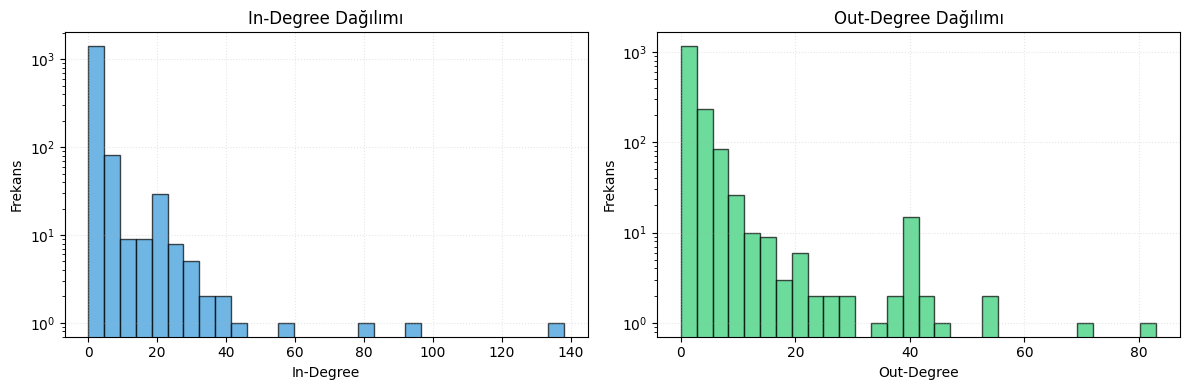

✅ Dağılım grafikleri kaydedildi


In [9]:
# Derece dağılımlarını görselleştir
in_vals = np.array(list(in_deg.values()))
out_vals = np.array(list(out_deg.values()))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# In-Degree histogram
axes[0].hist(in_vals, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Frekans')
axes[0].set_title('In-Degree Dağılımı')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Out-Degree histogram
axes[1].hist(out_vals, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Out-Degree')
axes[1].set_ylabel('Frekans')
axes[1].set_title('Out-Degree Dağılımı')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR / 'plots' / 'degree_distributions.png', dpi=150, bbox_inches='tight')
plt.savefig(OUTDIR / 'plots' / 'degree_distributions.svg', bbox_inches='tight')
plt.show()

print(f"✅ Dağılım grafikleri kaydedildi")

## 8. Top 10 Liderler

En yüksek merkeziyete sahip paketleri görselleştirelim.

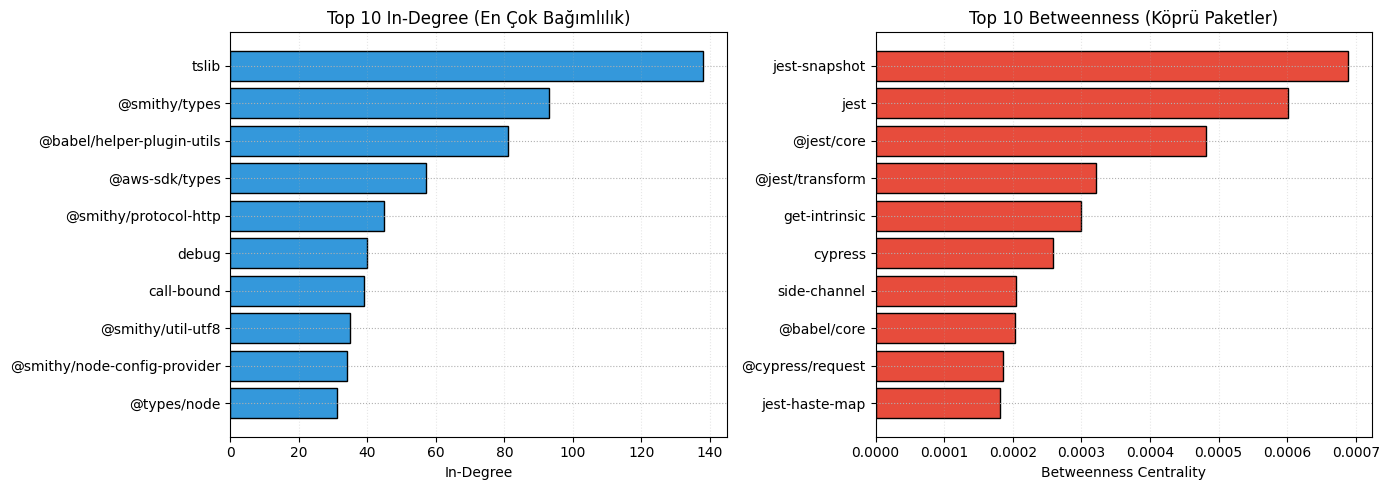

✅ Top 10 grafikleri kaydedildi


In [10]:
# En yüksek in-degree'li 10 paket
top10_in = sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:10]
packages_in = [pkg for pkg, _ in top10_in][::-1]
values_in = [val for _, val in top10_in][::-1]

# En yüksek betweenness'li 10 paket
top10_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:10]
packages_btw = [pkg for pkg, _ in top10_btw][::-1]
values_btw = [val for _, val in top10_btw][::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# In-Degree bar chart
axes[0].barh(packages_in, values_in, color='#3498db', edgecolor='black')
axes[0].set_xlabel('In-Degree')
axes[0].set_title('Top 10 In-Degree (En Çok Bağımlılık)')
axes[0].grid(axis='x', alpha=0.3)

# Betweenness bar chart
axes[1].barh(packages_btw, values_btw, color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Betweenness Centrality')
axes[1].set_title('Top 10 Betweenness (Köprü Paketler)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR / 'plots' / 'top10_leaders.png', dpi=150, bbox_inches='tight')
plt.savefig(OUTDIR / 'plots' / 'top10_leaders.svg', bbox_inches='tight')
plt.show()

print(f"✅ Top 10 grafikleri kaydedildi")

## 9. Korelasyon Analizi

Metrikler arasındaki ilişkileri scatter plot ile inceleyelim.

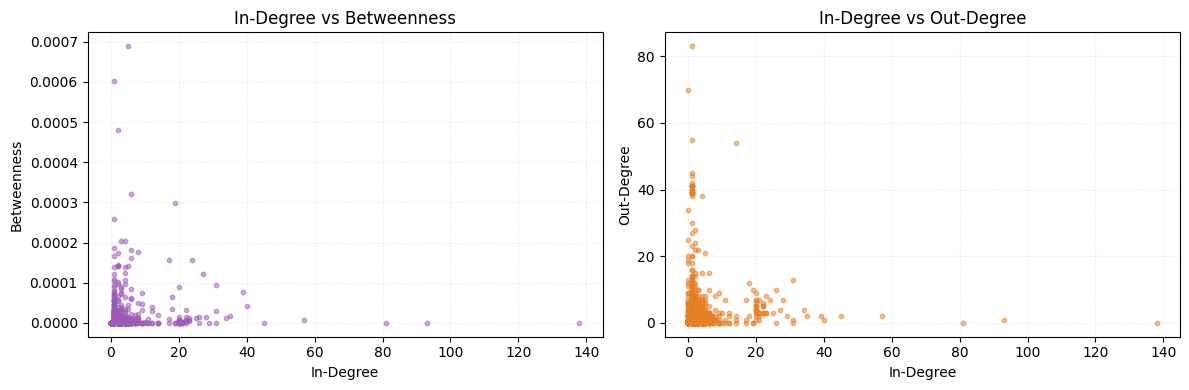

✅ Korelasyon grafikleri kaydedildi


In [11]:
# Metrik korelasyonları
all_packages = list(G.nodes())
in_values = [in_deg.get(pkg, 0) for pkg in all_packages]
out_values = [out_deg.get(pkg, 0) for pkg in all_packages]
btw_values = [btw.get(pkg, 0.0) for pkg in all_packages]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# In-Degree vs Betweenness
axes[0].scatter(in_values, btw_values, s=10, alpha=0.5, color='#9b59b6')
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Betweenness')
axes[0].set_title('In-Degree vs Betweenness')
axes[0].grid(alpha=0.3)

# In-Degree vs Out-Degree
axes[1].scatter(in_values, out_values, s=10, alpha=0.5, color='#e67e22')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Out-Degree')
axes[1].set_title('In-Degree vs Out-Degree')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR / 'plots' / 'metric_correlations.png', dpi=150, bbox_inches='tight')
plt.savefig(OUTDIR / 'plots' / 'metric_correlations.svg', bbox_inches='tight')
plt.show()

print(f"✅ Korelasyon grafikleri kaydedildi")

## 10. Risk Skorları: Top 20

En riskli paketleri görselleştirelim.

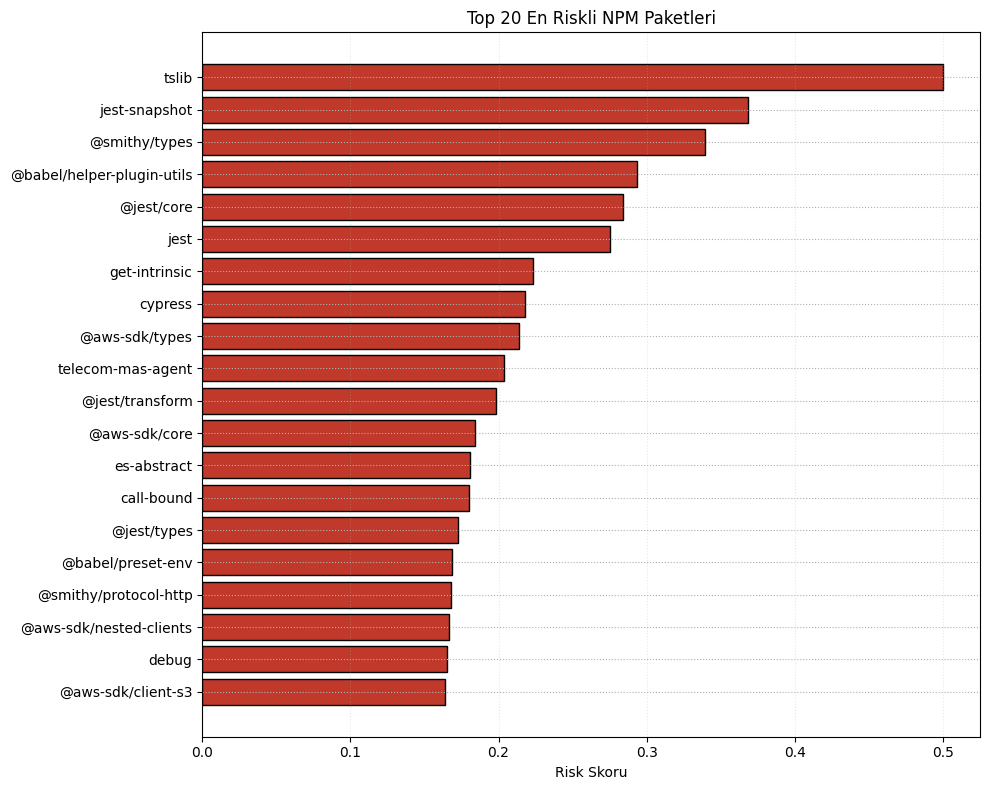

✅ Risk skoru grafikleri kaydedildi

📊 En Riskli 5 Paket:
   1. tslib                          - Risk: 0.5000
   2. jest-snapshot                  - Risk: 0.3687
   3. @smithy/types                  - Risk: 0.3394
   4. @babel/helper-plugin-utils     - Risk: 0.2935
   5. @jest/core                     - Risk: 0.2842


In [12]:
# En riskli 20 paketi göster
top20_risk = sorted(risk.items(), key=lambda x: x[1], reverse=True)[:20]
risk_packages = [pkg for pkg, _ in top20_risk][::-1]
risk_values = [val for _, val in top20_risk][::-1]

plt.figure(figsize=(10, 8), dpi=100)
plt.barh(risk_packages, risk_values, color='#c0392b', edgecolor='black')
plt.xlabel('Risk Skoru')
plt.title('Top 20 En Riskli NPM Paketleri')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR / 'plots' / 'top20_risk_scores.png', dpi=150, bbox_inches='tight')
plt.savefig(OUTDIR / 'plots' / 'top20_risk_scores.svg', bbox_inches='tight')
plt.show()

print(f"✅ Risk skoru grafikleri kaydedildi")
print(f"\n📊 En Riskli 5 Paket:")
for i, (pkg, score) in enumerate(top20_risk[:5], 1):
    print(f"   {i}. {pkg:30s} - Risk: {score:.4f}")

In [13]:
# Graf istatistiklerini hesapla
stats = {
    "nodes": G.number_of_nodes(),
    "edges": G.number_of_edges(),
    "avg_in_degree": np.mean(list(in_deg.values())),
    "avg_out_degree": np.mean(list(out_deg.values())),
    "avg_betweenness": np.mean(list(btw.values())),
    "density": nx.density(G),
    "is_connected": nx.is_weakly_connected(G)
}

# JSON olarak kaydet
with (OUTDIR / "graph_stats.json").open("w", encoding="utf-8") as f:
    json.dump(stats, f, indent=2, ensure_ascii=False)

print("📊 Graf İstatistikleri:")
print(f"   Düğüm sayısı: {stats['nodes']}")
print(f"   Kenar sayısı: {stats['edges']}")
print(f"   Yoğunluk (density): {stats['density']:.6f}")
print(f"   Ortalama in-degree: {stats['avg_in_degree']:.2f}")
print(f"   Ortalama out-degree: {stats['avg_out_degree']:.2f}")
print(f"   Zayıf bağlantılı mı? {stats['is_connected']}")
print(f"\n✅ İstatistikler kaydedildi: graph_stats.json")

📊 Graf İstatistikleri:
   Düğüm sayısı: 1559
   Kenar sayısı: 4076
   Yoğunluk (density): 0.001678
   Ortalama in-degree: 2.61
   Ortalama out-degree: 2.61
   Zayıf bağlantılı mı? False

✅ İstatistikler kaydedildi: graph_stats.json


In [14]:
# metrics_dict ve risks_dict oluştur (Gephi export için gerekli)
print("📋 Metrics ve risks dictionaries oluşturuluyor...")

metrics_dict = {}
with (OUTDIR / "metrics.csv").open(encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pkg = row.get("package", "")
        if pkg:
            metrics_dict[pkg] = row

risks_dict = {}
with (OUTDIR / "risk_scores.csv").open(encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pkg = row.get("package", "")
        if pkg:
            risks_dict[pkg] = row

print(f"✅ Dictionaries oluşturuldu: {len(metrics_dict)} metrics, {len(risks_dict)} risks")

📋 Metrics ve risks dictionaries oluşturuluyor...
✅ Dictionaries oluşturuldu: 1559 metrics, 1559 risks


## 12. Top-20 CSV Çıktıları

Analiz tamamlandı! Tüm çıktıları kontrol edelim.

In [15]:
# Top-20 CSV dosyaları oluştur (tüm düğümler için)
print("📝 Top-20 CSV dosyaları oluşturuluyor...")

# Top 20 In-Degree (tüm düğümler)
top_in_all = sorted(in_deg.items(), key=lambda kv: kv[1], reverse=True)[:20]
with (OUTDIR / "top20_in_degree.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["package", "in_degree"])
    for n, v in top_in_all:
        w.writerow([n, v])

# Top 20 Out-Degree (tüm düğümler)
top_out_all = sorted(out_deg.items(), key=lambda kv: kv[1], reverse=True)[:20]
with (OUTDIR / "top20_out_degree.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["package", "out_degree"])
    for n, v in top_out_all:
        w.writerow([n, v])

# Top 20 Betweenness (tüm düğümler)
top_btw_all = sorted(btw.items(), key=lambda kv: kv[1], reverse=True)[:20]
with (OUTDIR / "top20_betweenness.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["package", "betweenness"])
    for n, v in top_btw_all:
        w.writerow([n, f"{v:.6f}"])

# Top 20 In-Degree (sadece Top N cohort)
top_in_top = sorted(((n, in_deg.get(n, 0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:20]
with (OUTDIR / "top20_in_top.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["package", "in_degree"])
    for n, v in top_in_top:
        w.writerow([n, v])

# Top 20 Out-Degree (sadece Top N cohort)
top_out_top = sorted(((n, out_deg.get(n, 0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:20]
with (OUTDIR / "top20_out_top.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["package", "out_degree"])
    for n, v in top_out_top:
        w.writerow([n, v])

# Top 20 Betweenness (sadece Top N cohort)
top_btw_top = sorted(((n, btw.get(n, 0.0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:20]
with (OUTDIR / "top20_btw_top.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["package", "betweenness"])
    for n, v in top_btw_top:
        w.writerow([n, f"{v:.6f}"])

# Graph stats JSON'u CSV'ye çevir
stats_json_path = OUTDIR / "graph_stats.json"
if stats_json_path.exists():
    stats = json.loads(stats_json_path.read_text(encoding="utf-8"))
    csv_stats_path = OUTDIR / "graph_stats.csv"
    with csv_stats_path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["metric", "value"])
        for k, v in stats.items():
            w.writerow([k, v])
    print(f"✅ Graph stats CSV oluşturuldu: {csv_stats_path}")

print("✅ Tüm Top-20 CSV dosyaları oluşturuldu")

📝 Top-20 CSV dosyaları oluşturuluyor...
✅ Graph stats CSV oluşturuldu: ..\results\graph_stats.csv
✅ Tüm Top-20 CSV dosyaları oluşturuldu

✅ Graph stats CSV oluşturuldu: ..\results\graph_stats.csv
✅ Tüm Top-20 CSV dosyaları oluşturuldu


In [16]:
# Gephi için node ve edge CSV'lerini oluştur
print("🎨 Gephi export dosyaları oluşturuluyor...")

# metrics_dict ve risks_dict oluştur (Gephi export için gerekli)
id_map = ex.export_gephi_from_graph(G, metrics_dict, risks_dict, OUTDIR)

print(f"✅ Gephi dosyaları oluşturuldu:")
print(f"   • gephi_nodes.csv ({len(id_map)} düğüm)")
print(f"   • gephi_edges.csv ({G.number_of_edges()} kenar)")
print(f"\n💡 Gephi'de açmak için:")
print(f"   1. Import > Spreadsheet > gephi_nodes.csv (Nodes table)")
print(f"   2. Import > Spreadsheet > gephi_edges.csv (Edges table)")
print(f"   3. Layout: Force Atlas 2 veya Fruchterman Reingold")
print(f"   4. Node boyutu: in_degree sütunu")
print(f"   5. Node rengi: risk_score sütunu")

🎨 Gephi export dosyaları oluşturuluyor...
✓ Gephi dosyaları oluşturuldu:
  - ..\results\gephi_nodes.csv (1559 düğüm)
  - ..\results\gephi_edges.csv (4076 kenar)
✅ Gephi dosyaları oluşturuldu:
   • gephi_nodes.csv (1559 düğüm)
   • gephi_edges.csv (4076 kenar)

💡 Gephi'de açmak için:
   1. Import > Spreadsheet > gephi_nodes.csv (Nodes table)
   2. Import > Spreadsheet > gephi_edges.csv (Edges table)
   3. Layout: Force Atlas 2 veya Fruchterman Reingold
   4. Node boyutu: in_degree sütunu
   5. Node rengi: risk_score sütunu


## 14. Cascade Impact Analizi

In [17]:
# Her paket için cascade impact hesapla
print("🔍 Cascade impact hesaplanıyor...")
cascade_impact = ah.cascade_impact_counts(G, list(G.nodes()))
print(f"✅ {len(cascade_impact)} paket için cascade impact hesaplandı")

# Top 20 cascade impact
top20_cascade = sorted(cascade_impact.items(), key=lambda x: x[1], reverse=True)[:20]
print("\n📊 Top-20 En Yüksek Cascade Impact:")
for i, (pkg, count) in enumerate(top20_cascade, 1):
    print(f"{i:2d}. {pkg:40s} → {count:5d} paket etkilenir")

# Cascade impact CSV kaydet
cascade_path = OUTDIR / "cascade_impact.csv"
ah.save_cascade_impact(cascade_impact, cascade_path)
print(f"\n💾 Cascade impact kaydedildi: {cascade_path}")

# Risk vs Cascade Impact scatter plot
print("\n📈 Risk vs Cascade Impact grafiği çiziliyor...")
ah.plot_risk_vs_cascade(risk, cascade_impact, plots_dir)
print("✅ Grafik kaydedildi")

# Top-20 Cascade Impact bar chart
print("\n📊 Top-20 Cascade Impact grafiği çiziliyor...")
cascade_for_plot = {k: float(v) for k, v in cascade_impact.items()}
top20_cascade_dict = dict(sorted(cascade_for_plot.items(), key=lambda x: x[1], reverse=True)[:20])

fig, ax = plt.subplots(figsize=(10, 7))
labels = list(top20_cascade_dict.keys())
values = list(top20_cascade_dict.values())
ax.barh(range(len(values)), values, color="#10b981", alpha=0.85)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel("Etkilenen Paket Sayısı")
ax.set_title("Top-20 Cascade Impact (Supply Chain Attack Riski)")
plt.tight_layout()
cascade_plot_path = plots_dir / "top20_cascade_impact.png"
plt.savefig(cascade_plot_path, dpi=150, bbox_inches="tight")
plt.close()
print(f"✅ Grafik kaydedildi: {cascade_plot_path}")

🔍 Cascade impact hesaplanıyor...
✅ 1559 paket için cascade impact hesaplandı

📊 Top-20 En Yüksek Cascade Impact:
 1. tslib                                    →   153 paket etkilenir
 2. ms                                       →   129 paket etkilenir
 3. debug                                    →   120 paket etkilenir
 4. function-bind                            →   108 paket etkilenir
 5. hasown                                   →   102 paket etkilenir
 6. gopd                                     →   101 paket etkilenir
 7. es-errors                                →   101 paket etkilenir
 8. @babel/helper-plugin-utils               →   101 paket etkilenir
 9. @smithy/types                            →   100 paket etkilenir
10. @babel/helper-validator-identifier       →    95 paket etkilenir
11. es-define-property                       →    94 paket etkilenir
12. call-bind-apply-helpers                  →    93 paket etkilenir
13. dunder-proto                             →    92 paket 

## 15. Edge Betweenness

In [18]:
# Edge betweenness hesapla
print("🌉 Edge betweenness hesaplanıyor...")
print("   Not: Büyük ağlar için bu işlem uzun sürebilir...")

edge_btw_path = OUTDIR / "edge_betweenness_top10.csv"
ah.save_edge_betweenness_topn(G, 10, edge_btw_path)

print(f"✅ Top-10 edge betweenness kaydedildi: {edge_btw_path}")

# Dosyayı oku ve göster
with edge_btw_path.open(encoding="utf-8") as f:
    reader = csv.DictReader(f)
    edges = list(reader)

print("\n📊 Top-10 Kritik Köprü Kenarlar:")
for i, edge in enumerate(edges, 1):
    u, v, eb = edge['u'], edge['v'], edge['edge_betweenness']
    print(f"{i:2d}. {u:40s} → {v:40s} : {float(eb):.6f}")

🌉 Edge betweenness hesaplanıyor...
   Not: Büyük ağlar için bu işlem uzun sürebilir...
✅ Top-10 edge betweenness kaydedildi: ..\results\edge_betweenness_top10.csv

📊 Top-10 Kritik Köprü Kenarlar:
 1. jest                                     → @jest/core                               : 0.000142
 2. @jest/expect                             → jest-snapshot                            : 0.000100
 3. reflect.getprototypeof                   → which-builtin-type                       : 0.000094
 4. @jest/transform                          → babel-plugin-istanbul                    : 0.000086
 5. @babel/traverse                          → @babel/generator                         : 0.000082
 6. jest-snapshot                            → @jest/transform                          : 0.000081
 7. call-bound                               → get-intrinsic                            : 0.000081
 8. @babel/core                              → @babel/helper-compilation-targets        : 0.000078
 9. telecom-

## 16. Robustness Test

In [20]:
# En riskli 20 paketi çıkarıp ağın ne kadar etkilendiğini test et
print("🛡️ Robustness test başlıyor...")
print("   En riskli 20 paket çıkarılıyor...")

# Önce orijinal graf istatistiklerini al
before_stats = {
    "nodes": G.number_of_nodes(),
    "edges": G.number_of_edges(),
}

# En riskli 20 paketi belirle
top20_risky = sorted(risk.items(), key=lambda x: x[1], reverse=True)[:20]
risky_nodes = [pkg for pkg, _ in top20_risky]

# Paketler çıkarıldıktan sonraki istatistikler
after_stats = ah.robustness_remove_and_stats(G, risky_nodes)

print("\n📊 Robustness Test Sonuçları:")
print(f"   ÖNCE: {before_stats['nodes']} düğüm, {before_stats['edges']} kenar")
print(f"   SONRA: {int(after_stats['nodes'])} düğüm, {int(after_stats['edges'])} kenar")
print(f"   Kayıp: {before_stats['nodes'] - int(after_stats['nodes'])} düğüm ({100*(before_stats['nodes']-after_stats['nodes'])/before_stats['nodes']:.1f}%)")
print(f"   Kayıp: {before_stats['edges'] - int(after_stats['edges'])} kenar ({100*(before_stats['edges']-after_stats['edges'])/before_stats['edges']:.1f}%)")
print(f"   Bileşen sayısı: {int(after_stats['components_count'])}")
print(f"   En büyük bileşen: {int(after_stats['largest_component_size'])} düğüm")

# Sonuçları kaydet
robustness_path = OUTDIR / "robustness_test.json"
with robustness_path.open("w", encoding="utf-8") as f:
    json.dump({"before": before_stats, "after": after_stats}, f, indent=2)
print(f"\n💾 Robustness test sonuçları kaydedildi: {robustness_path}")

🛡️ Robustness test başlıyor...
   En riskli 20 paket çıkarılıyor...

📊 Robustness Test Sonuçları:
   ÖNCE: 1559 düğüm, 4076 kenar
   SONRA: 1539 düğüm, 3062 kenar
   Kayıp: 20 düğüm (1.3%)
   Kayıp: 1014 kenar (24.9%)
   Bileşen sayısı: 184
   En büyük bileşen: 1184 düğüm

💾 Robustness test sonuçları kaydedildi: ..\results\robustness_test.json

📊 Robustness Test Sonuçları:
   ÖNCE: 1559 düğüm, 4076 kenar
   SONRA: 1539 düğüm, 3062 kenar
   Kayıp: 20 düğüm (1.3%)
   Kayıp: 1014 kenar (24.9%)
   Bileşen sayısı: 184
   En büyük bileşen: 1184 düğüm

💾 Robustness test sonuçları kaydedildi: ..\results\robustness_test.json


## 17. Network Görselleştirmesi

In [26]:
# Network görselleştirmeleri
print("🎨 Network görselleştirmeleri oluşturuluyor...")
ah.plot_network_visualizations(G, top_set, plots_dir)
print("✅ Network görselleştirmeleri kaydedildi")

🎨 Network görselleştirmeleri oluşturuluyor...
✅ Network görselleştirmeleri kaydedildi
✅ Network görselleştirmeleri kaydedildi


## 13. README Dosyası

In [24]:
# README.md oluştur
print("📋 README.md oluşturuluyor...")
readme_path = OUTDIR / "README.md"
ah.save_report(in_deg, out_deg, btw, top_set, readme_path)
print(f"✅ README.md kaydedildi: {readme_path}")

📋 README.md oluşturuluyor...
✅ README.md kaydedildi: ..\results\README.md


## 18. LaTeX Tablo Üretimi

In [25]:
# LaTeX longtable formatında tablolar üret
print("📄 LaTeX tabloları oluşturuluyor...")

# Standart tablolar (özel formatlı)
ok1 = mt.write_metrics_top20_in(OUTDIR)
ok2 = mt.write_risk_top20(OUTDIR)
ok3 = mt.write_edge_betweenness_top10(OUTDIR)
ok4 = mt.write_cascade_impact_top20(OUTDIR)
ok5 = mt.write_metrics_top20_out(OUTDIR)
ok6 = mt.write_metrics_top20_betweenness(OUTDIR)

print(f"  metrics_top20_in_degree.tex: {'✅ OK' if ok1 else '⏭️  SKIP'}")
print(f"  risk_scores_top20.tex: {'✅ OK' if ok2 else '⏭️  SKIP'}")
print(f"  edge_betweenness_top10.tex: {'✅ OK' if ok3 else '⏭️  SKIP'}")
print(f"  cascade_impact_top20.tex: {'✅ OK' if ok4 else '⏭️  SKIP'}")
print(f"  metrics_top20_out_degree.tex: {'✅ OK' if ok5 else '⏭️  SKIP'}")
print(f"  metrics_top20_betweenness.tex: {'✅ OK' if ok6 else '⏭️  SKIP'}")

# Tüm CSV'ler için otomatik tablo üret
print("\n📋 Tüm CSV'ler için otomatik LaTeX tabloları oluşturuluyor...")
generated = mt.write_all_csv_tables(OUTDIR)
print(f"✅ {len(generated)} adet table_*.tex dosyası oluşturuldu")

# LaTeX dosyalarını listele
tex_files = list(OUTDIR.glob("*.tex"))
print(f"\n📄 Toplam {len(tex_files)} LaTeX dosyası:")
for tex_file in sorted(tex_files):
    print(f"   {tex_file.name}")

📄 LaTeX tabloları oluşturuluyor...
  metrics_top20_in_degree.tex: ✅ OK
  risk_scores_top20.tex: ✅ OK
  edge_betweenness_top10.tex: ✅ OK
  cascade_impact_top20.tex: ⏭️  SKIP
  metrics_top20_out_degree.tex: ✅ OK
  metrics_top20_betweenness.tex: ✅ OK

📋 Tüm CSV'ler için otomatik LaTeX tabloları oluşturuluyor...
✅ 14 adet table_*.tex dosyası oluşturuldu

📄 Toplam 19 LaTeX dosyası:
   edge_betweenness_top10.tex
   metrics_top20_betweenness.tex
   metrics_top20_in_degree.tex
   metrics_top20_out_degree.tex
   risk_scores_top20.tex
   table_cascade_impact.tex
   table_edge_betweenness_top10.tex
   table_edges.tex
   table_gephi_edges.tex
   table_gephi_nodes.tex
   table_graph_stats.tex
   table_metrics.tex
   table_risk_scores.tex
   table_top20_betweenness.tex
   table_top20_btw_top.tex
   table_top20_in_degree.tex
   table_top20_in_top.tex
   table_top20_out_degree.tex
   table_top20_out_top.tex
✅ 14 adet table_*.tex dosyası oluşturuldu

📄 Toplam 19 LaTeX dosyası:
   edge_betweenness_top10